In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.
/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/poudelas/anaco

In [2]:
import tensorflow as tf

In [3]:
# Set some parameters
BATCH_SIZE = 10 # the higher the better
IMG_WIDTH = 96 # for faster computing on kaggle
IMG_HEIGHT = 96 # for faster computing on kaggle
IMG_CHANNELS = 3
TRAIN_PATH = '/media/poudelas/24f81228-8af6-4609-aa17-d48ef8ddc61f/Data/data-science-bowl-2018/stage1_train/train/'
TEST_PATH = '/media/poudelas/24f81228-8af6-4609-aa17-d48ef8ddc61f/Data/data-science-bowl-2018/stage1_train/validation/'

seed = 42

In [4]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
np.random.seed(10)

StopIteration: 

In [ ]:
#Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# # Get and resize test images
# X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# sizes_test = []
# print('Getting and resizing test images ... ')
# sys.stdout.flush()
# for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
#     path = TEST_PATH + id_
#     img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
#     sizes_test.append([img.shape[0], img.shape[1]])
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_test[n] = img

# print('Done!')

Getting and resizing train images and masks ... 


 24%|██▍       | 148/608 [01:05<06:23,  1.20it/s]

In [33]:
X_valid = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_valid = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_valid[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_valid[n] = mask


Getting and resizing train images and masks ... 


100%|██████████| 62/62 [00:17<00:00,  3.59it/s]


In [34]:
BATCH_SIZE = 10
seed = 1
from keras.preprocessing import image
# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(Y_train, augment=True, seed=seed)

x=image_datagen.flow(X_train,batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train,batch_size=BATCH_SIZE,shuffle=True, seed=seed)

In [35]:
#X_train, Y_train = get_data(path_train, train=True)
BATCH_SIZE = 10
seed = 1
from keras.preprocessing import image
# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator()
mask_datagen = image.ImageDataGenerator()

# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(X_valid, seed=seed)
mask_datagen.fit(Y_valid, seed=seed)

x_val=image_datagen.flow(X_valid,batch_size=BATCH_SIZE,seed=seed)
y_val=mask_datagen.flow(Y_valid,batch_size=BATCH_SIZE,seed=seed)

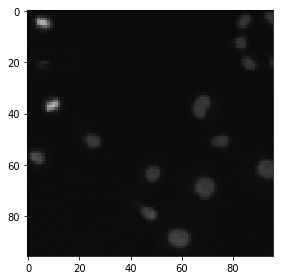

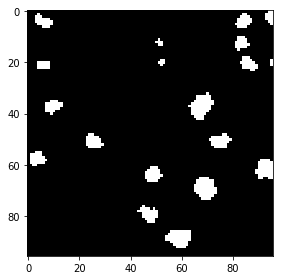

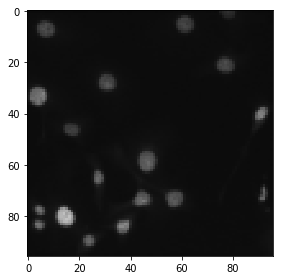

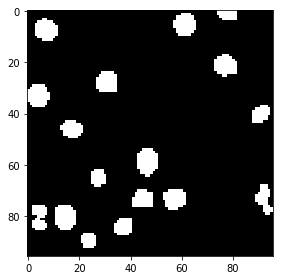

In [37]:
from matplotlib import pyplot as plt
%matplotlib inline

imshow(x.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y.next()[0].astype(np.uint8)*255))
plt.show()
imshow(x_val.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y_val.next()[0].astype(np.uint8)*255))
plt.show()

In [38]:
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

In [40]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [68]:
# from segmentation_models import Unet, Nestnet, Xnet
# model = Xnet(backbone_name='resnet50', encoder_weights='imagenet', decoder_block_type='transpose')
# print(model.summary())
import efficientnet.keras as efn
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers import LeakyReLU, Add, Input,MaxPool2D,UpSampling2D,concatenate,Conv2DTranspose,BatchNormalization,Dropout,Activation,add,multiply
base_model = efn.EfficientNetB0(weights='imagenet',include_top=False,input_shape=(None,None,3))
input_1 = base_model.get_layer('input_1').output
input_model = base_model.input
start_neurons = 8
dropout_ratio = 0.1

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x
def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3, 3))
    x = convolution_block(x, num_filters, (3, 3), activation=False)
    x = Add()([x, blockInput])
    return x
def attention(first_layer, second_layer,number_of_channel):
    first = Conv2D(number_of_channel, [1, 1], strides=[1, 1])(first_layer)
    second = Conv2D(number_of_channel, [1, 1], strides=[1, 1])(second_layer)
    f = Activation('relu')(add([first, second]))

    psi_f = Conv2D(1, [1, 1], strides=[1, 1])(f)
    rate = Activation('sigmoid')(psi_f)

    att_x = multiply([first, rate])
    return att_x

def reduce_dimension(layer, n):
    layer = MaxPool2D(pool_size=(n,n),padding='same')(layer)
    return layer

conv5 = base_model.get_layer('top_activation').output
conv4 = base_model.get_layer('block6a_expand_activation').output
conv3 = base_model.get_layer('block4a_expand_activation').output
conv2 = base_model.get_layer('block3a_expand_activation').output
conv1 = base_model.get_layer('block2a_expand_activation').output

reduce_layer_conv1 = reduce_dimension(conv1,2)
# reduce_layer_conv1 = LeakyReLU(alpha=0.1)(reduce_layer_conv1)
# reduce_layer_conv1 = BatchNormalization()(reduce_layer_conv1)
reduce_layer_conv1 = reduce_dimension(reduce_layer_conv1,2)
# reduce_layer_conv1 = LeakyReLU(alpha=0.1)(reduce_layer_conv1)
# reduce_layer_conv1 = BatchNormalization()(reduce_layer_conv1)

reduce_layer_conv2 = reduce_dimension(conv2,2)
# reduce_layer_conv2 = LeakyReLU(alpha=0.1)(reduce_layer_conv2)
# reduce_layer_conv2 = BatchNormalization()(reduce_layer_conv2)

reduce_layer_conv3 = conv3

up_layer_conv4 = Conv2DTranspose(240,(3,3),strides=(2,2),padding="same")(conv4)
up_layer_conv4 = LeakyReLU(alpha=0.1)(up_layer_conv4)
up_layer_conv4 = BatchNormalization()(up_layer_conv4)

up_layer_conv5 = Conv2DTranspose(672,(3,3),strides=(2,2),padding="same")(conv5)
up_layer_conv5 = LeakyReLU(alpha=0.1)(up_layer_conv5)
up_layer_conv5 = BatchNormalization()(up_layer_conv5)
up_layer_conv5 = Conv2DTranspose(240,(3,3),strides=(2,2),padding="same")(up_layer_conv5)
up_layer_conv5 = LeakyReLU(alpha=0.1)(up_layer_conv5)
up_layer_conv5 = BatchNormalization()(up_layer_conv5)

merged_global_features = concatenate([reduce_layer_conv1,reduce_layer_conv2,reduce_layer_conv3,up_layer_conv4,up_layer_conv5])
merged_global_features = Conv2D(960, (1, 1), strides=1, padding="same")(merged_global_features)
merged_global_features = LeakyReLU(alpha=0.1)(merged_global_features)
merged_global_features = BatchNormalization()(merged_global_features)

#Middle 7*7
convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same",name='conv_middle')(conv5)
convm = residual_block(convm,start_neurons * 32)
convm = residual_block(convm,start_neurons * 32)
convm = LeakyReLU(alpha=0.1)(convm) #7*7

#14*14
merged_global_features_reduced_2 = reduce_dimension(merged_global_features,2)
merged_global_features_reduced_2 = Conv2D(672, (3, 3), activation='relu', padding="same",name='merged_global_features_reduced_2')(merged_global_features_reduced_2)
merged_global_features_reduced_2 = BatchNormalization()(merged_global_features_reduced_2)
deconv4_attention = attention(conv4,merged_global_features_reduced_2,672)
deconv4 = Conv2DTranspose(start_neurons*16,(3,3),strides=(2,2),padding="same")(convm)
uconv4 = concatenate([deconv4,deconv4_attention])
uconv4 = Dropout(dropout_ratio)(uconv4)
uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
uconv4 = residual_block(uconv4,start_neurons * 16)
uconv4 = LeakyReLU(alpha=0.1)(uconv4)

#28*28
merged_global_features_no_reduce = Conv2D(240, (3, 3), activation='relu', padding="same",name='merged_global_features_no_reduce')(merged_global_features)
deconv3_attention = attention(conv3,merged_global_features_no_reduce,240)
deconv3 = Conv2DTranspose(start_neurons*8,(3,3),strides=(2,2),padding="same")(uconv4)
uconv3 = concatenate([deconv3,deconv3_attention])
uconv3 = Dropout(dropout_ratio)(uconv3)
uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
uconv3 = residual_block(uconv3,start_neurons * 8)
uconv3 = LeakyReLU(alpha=0.1)(uconv3)

#56*56
merged_global_features_up_2 = Conv2DTranspose(144,(3,3),strides=(2,2),padding="same")(merged_global_features)
merged_global_features_up_2 = LeakyReLU(alpha=0.1)(merged_global_features_up_2)
merged_global_features_up_2 = BatchNormalization()(merged_global_features_up_2)
deconv2_attention = attention(conv2,merged_global_features_up_2,144)
deconv2 = Conv2DTranspose(start_neurons*4,(3,3),strides=(2,2),padding="same")(uconv3)
uconv2 = concatenate([deconv2,deconv2_attention])
uconv2 = Dropout(dropout_ratio)(uconv2)
uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
uconv2 = residual_block(uconv2,start_neurons * 4)
uconv2 = LeakyReLU(alpha=0.1)(uconv2)

#112*112
merged_global_features_up_4 = Conv2DTranspose(144,(3,3),strides=(2,2),padding="same")(merged_global_features)
merged_global_features_up_4 = LeakyReLU(alpha=0.1)(merged_global_features_up_4)
merged_global_features_up_4 = BatchNormalization()(merged_global_features_up_4)
merged_global_features_up_4 = Conv2DTranspose(96,(3,3),strides=(2,2),padding="same")(merged_global_features_up_4)
merged_global_features_up_4 = LeakyReLU(alpha=0.1)(merged_global_features_up_4)
merged_global_features_up_4 = BatchNormalization()(merged_global_features_up_4)
deconv1_attention = attention(conv1,merged_global_features_up_4,96)
deconv1 = Conv2DTranspose(start_neurons*2,(3,3),strides=(2,2),padding="same")(uconv2)
uconv1 = concatenate([deconv1,deconv1_attention])
uconv1 = Dropout(dropout_ratio)(uconv1)
uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
uconv1 = residual_block(uconv1,start_neurons * 2)
uconv1 = LeakyReLU(alpha=0.1)(uconv1)

#224*224
deconv0 = Conv2DTranspose(start_neurons*1,(3,3),strides=(2,2),padding="same")(uconv1)
uconv0 = Dropout(dropout_ratio)(deconv0)
uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
uconv0 = residual_block(uconv0,start_neurons * 1)
uconv0 = LeakyReLU(alpha=0.1)(uconv0)

output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)

model = Model(input_model,[output_layer])
print(model.summary())

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [70]:
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
model.compile(optimizer=Adam(lr = 0.001),loss='binary_crossentropy', metrics=[dice_coef,mean_iou])
# Fit model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
tensorboard = TensorBoard(log_dir='./proposed_nuclei',histogram_freq=0,write_graph=True,write_images=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                   patience=8, min_lr=0.0000001, verbose=1,cooldown=1)
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('proposed_nuclei.h5', verbose=1, save_best_only=True)
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=100, callbacks=[tensorboard, checkpointer,reduce_lr,earlystopper])

Epoch 1/100
250/250 [==============================] - 47s 188ms/step - loss: 0.1112 - dice_coef: 0.8542 - mean_iou: 0.8411 - val_loss: 0.0810 - val_dice_coef: 0.8799 - val_mean_iou: 0.8561

Epoch 00001: val_loss improved from inf to 0.08096, saving model to proposed_nuclei.h5
Epoch 2/100
250/250 [==============================] - 34s 135ms/step - loss: 0.1050 - dice_coef: 0.8601 - mean_iou: 0.8577 - val_loss: 0.0876 - val_dice_coef: 0.8633 - val_mean_iou: 0.8587

Epoch 00002: val_loss did not improve from 0.08096
Epoch 3/100
250/250 [==============================] - 34s 135ms/step - loss: 0.1060 - dice_coef: 0.8590 - mean_iou: 0.8585 - val_loss: 0.0863 - val_dice_coef: 0.8714 - val_mean_iou: 0.8589

Epoch 00003: val_loss did not improve from 0.08096
Epoch 4/100
250/250 [==============================] - 34s 135ms/step - loss: 0.1051 - dice_coef: 0.8598 - mean_iou: 0.8591 - val_loss: 0.0865 - val_dice_coef: 0.8640 - val_mean_iou: 0.8595

Epoch 00004: val_loss did not improve from 0.08

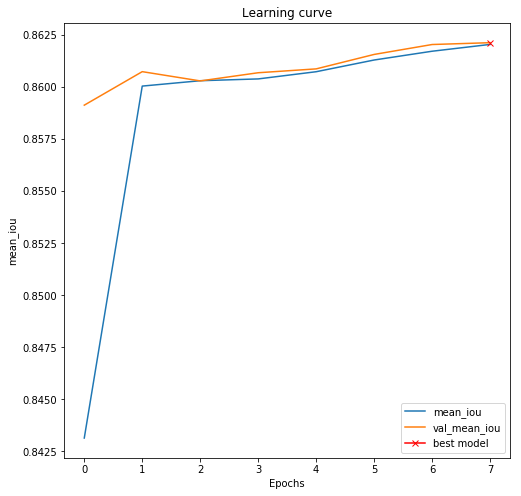

In [63]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["mean_iou"], label="mean_iou")
plt.plot(results.history["val_mean_iou"], label="val_mean_iou")
plt.plot( np.argmax(results.history["val_mean_iou"]), np.max(results.history["val_mean_iou"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("mean_iou")
plt.legend();

In [71]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)


# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

62/62 [==============================] - 0s 6ms/step


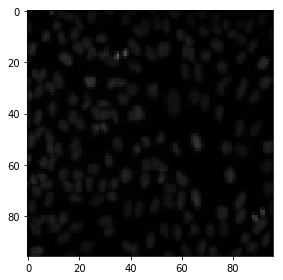

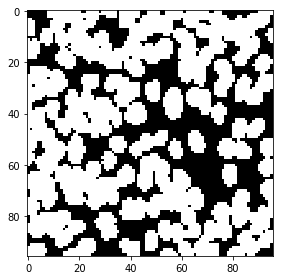

/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


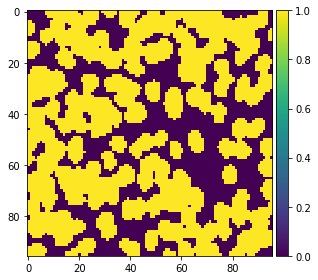

In [72]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

(62, 96, 96, 1)


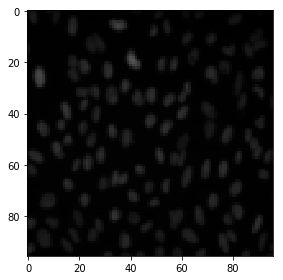

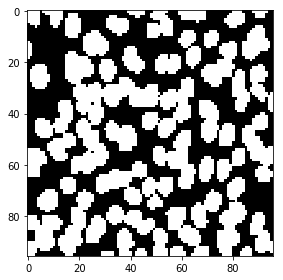

/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


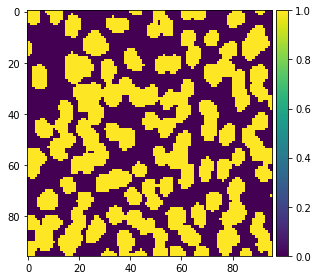

In [73]:
import cv2
print(preds_val_t.shape)
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_valid[ix])
plt.show()
imshow(np.squeeze(Y_valid[ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()


In [74]:
for i in range(len(preds_val_t)):
    #cv2.imwrite('./visualize/nuclei_segmentation/uentplusplus/images/val'+str(i)+'.jpg',cv2.cvtColor(X_valid[i], cv2.COLOR_BGR2RGB))
    #cv2.imwrite('./visualize/nuclei_segmentation/uentplusplus/Ground_truth/val'+str(i)+'.jpg',np.squeeze(Y_valid[i]*255))
    cv2.imwrite('./visualize/nuclei_segmentation/proposednet/predicted/val'+str(i)+'.jpg',np.squeeze(preds_val_t[i]*255))

# Upsampling 224,224,3

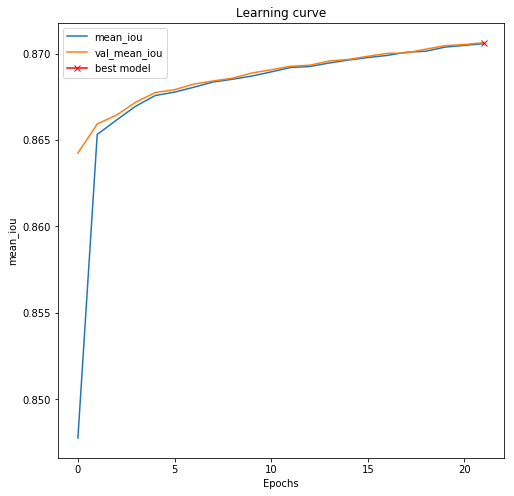

In [27]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results1.history["mean_iou"], label="mean_iou")
plt.plot(results1.history["val_mean_iou"], label="val_mean_iou")
plt.plot( np.argmax(results1.history["val_mean_iou"]), np.max(results1.history["val_mean_iou"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("mean_iou")
plt.legend();

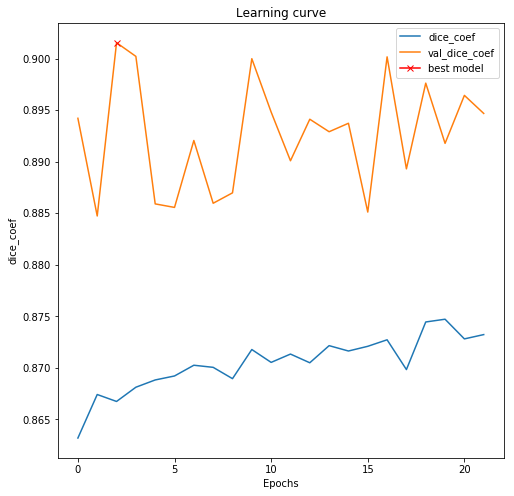

In [28]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results1.history["dice_coef"], label="dice_coef")
plt.plot(results1.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmax(results1.history["val_dice_coef"]), np.max(results1.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("dice_coef")
plt.legend();

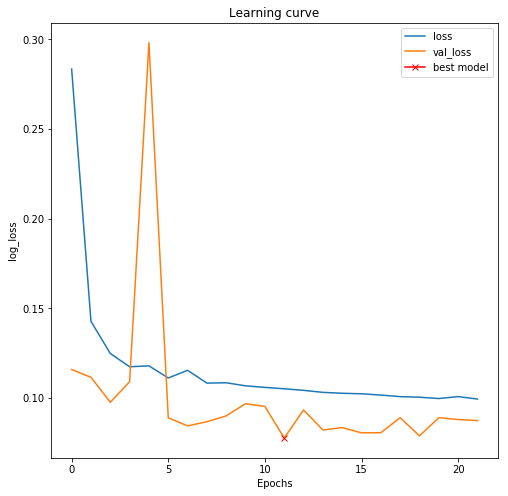

In [20]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results1.history["loss"], label="loss")
plt.plot(results1.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results1.history["val_loss"]), np.min(results1.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [17]:
# from keras.optimizers import Adam
# model.compile(optimizer=Adam(lr = 0.001),loss='binary_crossentropy', metrics=[dice_coef,mean_iou])
# # Fit model
# from keras.callbacks import EarlyStopping, ModelCheckpoint
# earlystopper = EarlyStopping(patience=10, verbose=1)
# checkpointer = ModelCheckpoint('model-unet.h5', verbose=1, save_best_only=True)
# results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
#                               epochs=100, callbacks=[earlystopper, checkpointer])

Epoch 1/100
250/250 [==============================] - 36s 145ms/step - loss: 0.2229 - dice_coef: 0.7072 - mean_iou: 0.6971 - val_loss: 0.1094 - val_dice_coef: 0.8502 - val_mean_iou: 0.7752

Epoch 00001: val_loss improved from inf to 0.10937, saving model to model-unet.h5
Epoch 2/100
250/250 [==============================] - 21s 83ms/step - loss: 0.1355 - dice_coef: 0.8105 - mean_iou: 0.7937 - val_loss: 0.1042 - val_dice_coef: 0.8683 - val_mean_iou: 0.8059

Epoch 00002: val_loss improved from 0.10937 to 0.10420, saving model to model-unet.h5
Epoch 3/100
250/250 [==============================] - 21s 83ms/step - loss: 0.1234 - dice_coef: 0.8340 - mean_iou: 0.8129 - val_loss: 0.1037 - val_dice_coef: 0.8679 - val_mean_iou: 0.8187

Epoch 00003: val_loss improved from 0.10420 to 0.10372, saving model to model-unet.h5
Epoch 4/100
250/250 [==============================] - 21s 83ms/step - loss: 0.1160 - dice_coef: 0.8443 - mean_iou: 0.8230 - val_loss: 0.1120 - val_dice_coef: 0.8564 - val_mea

,a
0,<keras.callbacks.History object at 0x7fb105faa...


# EfficientUnet

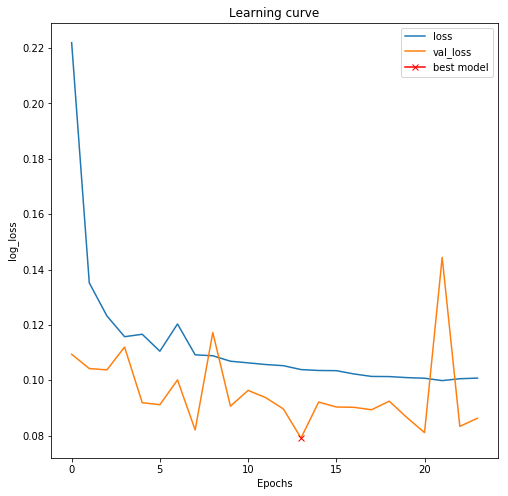

In [19]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

# ResnetUnet

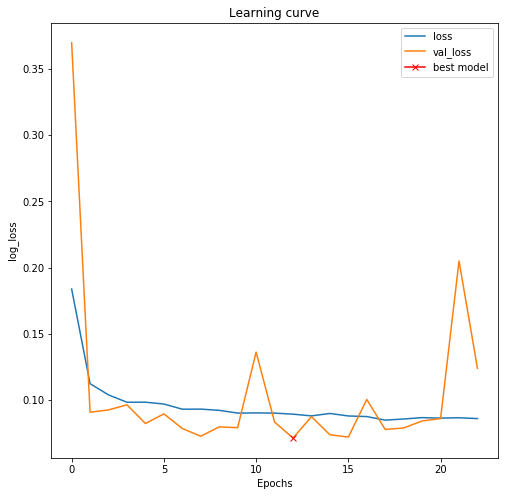

In [51]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

# UNetPlusPlus

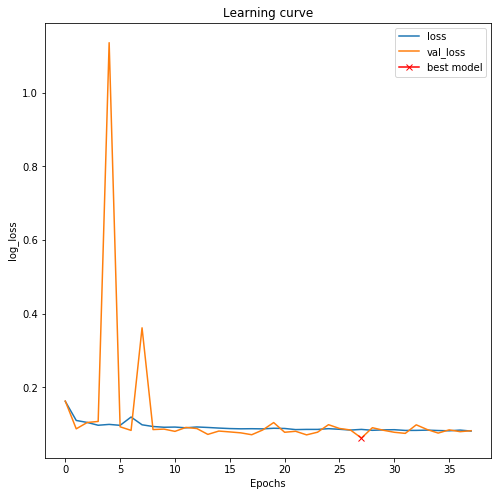

In [48]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [10]:
# Predict on train, val and test
model = load_model('Unet_simple.h5', custom_objects={'mean_iou': mean_iou,'dice_coef':dice_coef})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

ValueError: Unknown activation function:swish

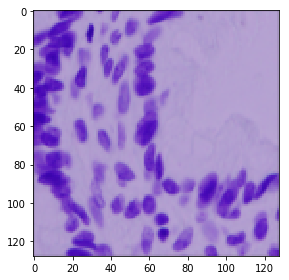

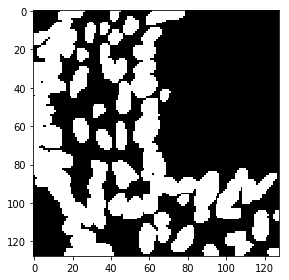

/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


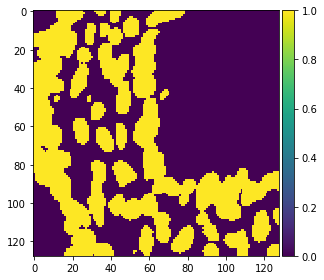

In [53]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

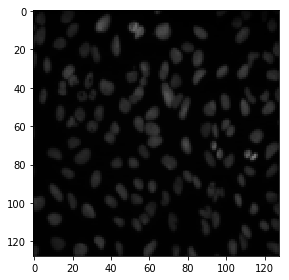

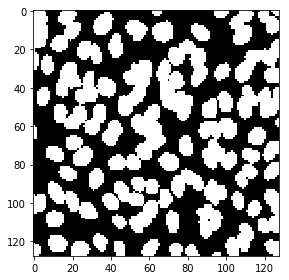

/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


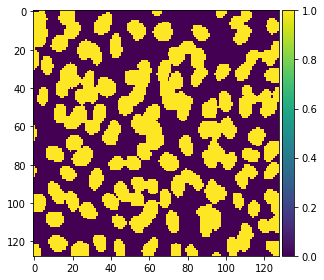

In [55]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [56]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [57]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [59]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1-DA2-batch10_unetplusplus.csv', index=True)